(04-nls)=
# Nonlinear Least Squares

**Learning Objectives**: In this notebook, you will learn

- the mathematical formulation of *nonlinear least squares* (NLS)
- the need for general-purpose optimization with NLS
- how to use the `fit_nls()` routine to perform NLS
- how to recognize and resolve premature optimization termination
- how to recognize and resolve issues of model unidentifiability
- how to recognize and resolve issues of local minima


In [1]:
import grama as gr
import numpy as np
import pandas as pd
import warnings
from plotnine import *

from grama.models import make_trajectory_linear
from grama.data import df_trajectory_windowed

X = gr.Intention()

## Definitions <a id="definitions"></a>

**Definition**: The *mean squared error* (MSE) is defined by

$$\text{MSE}(\theta) = \sum_{i=1}^{N_{\text{data}}} (\hat{f}_i(\theta) - f_i)^2.$$

**Definition**: *Nonlinear least squares* (NLS) optimization is the fitting of a model $\hat{f}(\theta)$ via minimization of the MSE

$$\theta^* = \text{argmin}_{\theta} \text{MSE}(\theta),$$

where $\hat{f}(\theta)$ is nonlinear in $\theta$.

In contrast with ordinary least squares, the model $\hat{f}(\theta)$ does not have any special structure. This introduces a few new challenges.


## The Need for General-purpose Optimization <a id="challenge-opt"></a>

In contrast with ordinary least squares---which has special structure that admits an analytic solution to minimize the MSE---the NLS minimization problem does not have a general analytic solution. This means one must use some form of general-purpose optimization to minimize the MSE. A generic procedure is as follows:

### Procedure

1. Select initial guess $\theta_j$ for $j=0$
1. Compute fit $\hat{f}_i(\theta_j)$ for each data point 
1. Compute mean squared error $\text{MSE}(\theta_j)$
1. Select next $\theta_{j+1}$ by seeking a minimum of MSE
1. Repeat from (2) until MSE is sufficiently converged

The selection of an initial guess $\theta_0$ and the procedure for selecting new iterations $\theta_{j+1}$ are important considerations, but are also highly problem-dependent. 

The [Grama](#grama) section below lists implementations of NLS, including the routine `gr.fit_nls()`. This general-purpose routine provides sensible defaults for $\theta_0$ and an iteration strategy, but is customizable.


### Routine: `fit_nls()`

The workhorse Grama routine for solving nonlinear least squares problems is `fit_nls()`. As the prefix implies this is a routine that takes a dataset and returns a Grama model. The primary benefit of `fit_nls()` (over other empirical fitting routines) is that it takes a Grama model as an *input*: This allows the user to fully specify the model structure. The routine `fit_nls()` compares the provided dataset and model, automatically determines which parameters to fit, and performs iterative minimization of the MSE to find best-fit parameter values.

Under the hood `fit_nls()` calls the [scipy.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) routine with the bounds provided by the model to fit. Since only a subset of scipy's optimization routines are compatible with bounds, `fit_nls()` can only use those optimizers. As of writing (2020-11-16) those routines are `L-BFGS-B, TNC, SLSQP, Powell,` and `trust-constr`.

You can read the documentation for `fit_nls()` for more information! Don't forget that you can also reference this while coding to remind yourself of the routine's arguments.


In [2]:
# help(gr.fit_nls) # Uncomment to read the documentation


## Quick Demonstration

To start, let's take a look at a quick demonstration of using `fit_nls()`.


In [3]:
## Load pre-made trajectory model
md_trajectory = make_trajectory_linear()
## Fit trajectory model with NLS
md_trajectory_fitted = gr.fit_nls(
    df_trajectory_windowed,
    md=md_trajectory,
    method="SLSQP",
)

... fit_nls setting out = ['y', 'x']
... eval_nls setting out = ['y', 'x']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = ['t']


        v0         u0      tau  v0_0  u0_0  tau_0  success  \
0  28.2348  18.792167  2.80225   0.1   0.1   0.05     True   

                                message  n_iter       mse  
0  Optimization terminated successfully      46  0.093358  


Let's parse the printout from `fit_nls()`:

`fit_nls()` is implemented using `eval_nls()` to carry out the optimization, the printout `setting` lines report that the routine has inspected the provided data and Grama model and determined a set of outputs `out` for which data is available, a set of variables `var_fix` to fix to constant values, and a set of variables `var_feat` to treat as features in the model that index different observations on the outputs.

`fit_nls()` also echoes the best-fit parameter values along with optimizer details; the routine denotes initial guess values with the `_0` suffix along with the best-fit parameter values. Optimization details include the `success, message` codes and the `MSE` value associated with each restart. If multiple restarts are used, then a single row is reported for each restart.

While these numeric details are very useful for debugging, it is important to conduct a visual inspection of fitted model results as well.


... provided columns intersect model output.
eval_df() is dropping {'y', 'x'}


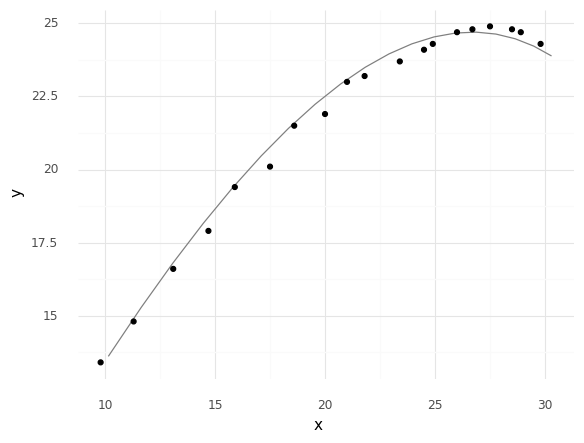

<ggplot: (8778601249785)>

In [4]:
## Evaluate and plot fitted trajectory
df_trajectory_fitted = gr.eval_df(md_trajectory_fitted, df=df_trajectory_windowed)
(
    ggplot(mapping=aes("x", "y"))
    + geom_line(data=df_trajectory_fitted, color="grey")
    + geom_point(data=df_trajectory_windowed)
    + theme_minimal()
)

A quick visual inspection of the model results indicates a good fit, but this is different from the model being *validated*. See the [chapter on model-form error](02-model-form-error) for more information.


### UQ Capabilities: Linearized and Pooled parameter estimation

The `fit_nls()` routine implements an approximate method for parameter uncertainty quantification based on a *linearized* model. This option is enabled by setting `uq_method="linpool"`. While fitting is carried out using the full nonlinear model, a post-processing step is carried out at the optimized parameter value $\theta^*$.

This statistical procedure assumes the following model

$$f_{i, j} = \hat{f}_{i, j} + \epsilon_{i, j},$$

where $i$ indexes observations, $j$ indexes model outputs, and $\epsilon_{i,j} \sim N(0, \sigma_j^2)$ are iid. Under these assumptions the parameter are asymptotically normally distributed, with correlations related to the gradient of the function {cite}`rukstuhl2010introduction`. Since the parameters are shared among all function outputs, the `linpool` method simply averages (pools) the variance matrices from each output.

The following example demonstrates this UQ procedure on the trajectory example: fitting the nonlinear model, estimating a distribution for the parameters, and drawing an ensemble of trajectories to illustrate the parameteric uncertainty in the resulting fit.


... fit_nls setting out = ['y', 'x']
... eval_nls setting out = ['y', 'x']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = ['t']
        v0         u0      tau  v0_0  u0_0  tau_0  success  \
0  28.2348  18.792167  2.80225   0.1   0.1   0.05     True   

                                message  n_iter       mse  
0  Optimization terminated successfully      46  0.093358  
... provided columns intersect model output.
eval_df() is dropping {'y', 'x'}
... provided columns intersect model output.
eval_df() is dropping {'y', 'x'}


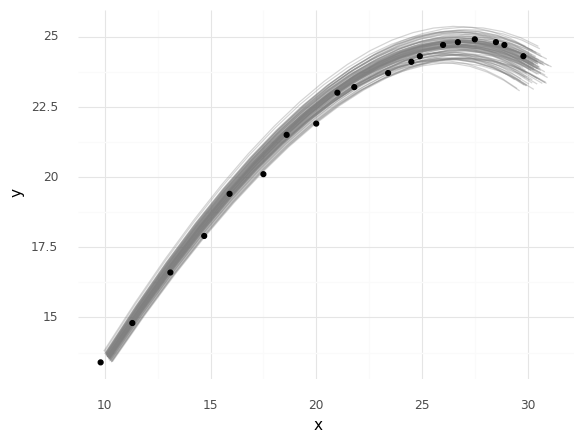

<ggplot: (8778601135745)>

In [5]:
## Fit trajectory model with linpool enabled
md_trajectory_uq = gr.fit_nls(
    df_trajectory_windowed,
    md=md_trajectory,
    method="SLSQP",
    uq_method="linpool",
)
## Visualize ensemble of trajectories
df_trajectory_uq = gr.eval_monte_carlo(md_trajectory_uq, n=100, df_det=df_trajectory_windowed)
(
    ggplot(mapping=aes("x", "y"))
    + geom_line(
        data=df_trajectory_uq, 
        mapping=aes(group="tau"), 
        alpha=1/3,
        color="grey",
    )
    + geom_point(data=df_trajectory_windowed)
    + theme_minimal()
)


Combining UQ methods with NLS provides more information; above we can see that the uncertainty in the trajectory is small near the beginning but begins to spread as deviations accumulate over time. When making predictions with NLS we can use UQ techniques to construct error bars. This can help us accurately assess the confidence in our predictions, enabling better decision making.


## Challenges

---

Since NLS is a general technique that one can apply to fit an arbitrary model, it is important to be alert for many *challenges* that may arise in fitting a model. The following sections details common challenges in applying NLS and some strategies to overcome those challenges.

### Challenge: Premature Termination <a id="challenge-termination"></a>

Generally we want the *best* fit of a model, as represented by the *globally minimum* MSE. However, practical optimization algorithms are only capable of converging to within a finite *tolerance* of the true optimum. If optimization stops before it is sufficiently converged, then the model fit may not be sufficiently accurate for our purposes.

To illustrate the challenges of premature optimization termination, let's set up an example where the MSE will tend to be dramatically large. To that end, the following code sets up an exponential model.


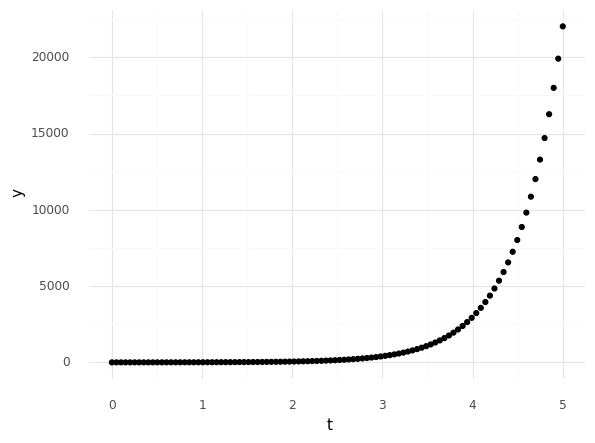

<ggplot: (8778599043213)>

In [6]:
## Define exponential model
md_decay = (
    gr.Model("Decay Model")
    >> gr.cp_function(
        fun=lambda x: np.exp(x[0] * x[1]),
        var=["a", "t"],
        out=["y"],
    )
    >> gr.cp_bounds(
        a=(1, 10),
        t=(0, 5),
    )
)
## Generate data under a = 2
df_decay_data = gr.eval_df(md_decay, df=gr.df_make(a=2, t=np.linspace(0, 5, num=100)))
## Plot
(
    ggplot(df_decay_data, aes("t", "y"))
    + geom_point()
    + theme_minimal()
)

To demonstrate what happens when optimization stops prematurely, let's set the optimization tolerances to be deliberately loose.


In [7]:
md_decay_fit = gr.fit_nls(
    df_decay_data[["t", "y"]],
    md=md_decay,
    # Deliberately set a loose convergence tolerance
    ftol=1,
    gtol=1,
)


... fit_nls setting out = ['y']
... eval_nls setting out = ['y']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = ['t']
     a  a_0  success                                          message  n_iter  \
0  1.0  5.5     True  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH       1   

            mse  
0  2.606039e+07  


Note that the fitting results indicate that optimization terminated "successfully" (`success == True`), but clearly the fitted value for `a` does not match what we set above (`a=2`). A visual inspection of results gives a clearer picture of the misfit.


... provided columns intersect model output.
eval_df() is dropping {'a', 'y'}


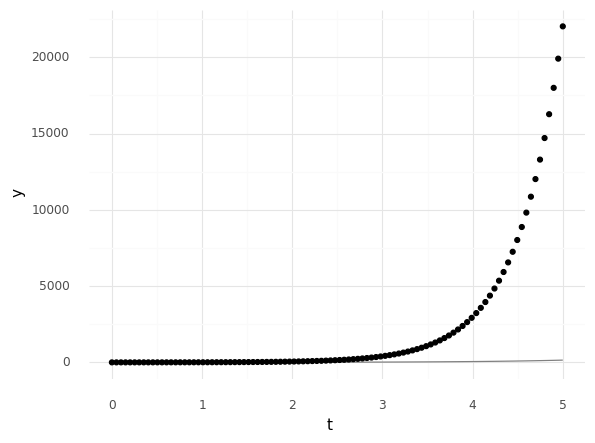

<ggplot: (8778599968461)>

In [8]:
df_decay_fit1 = gr.eval_df(md_decay_fit, df=df_decay_data)

(
    ggplot(mapping=aes("t", "y"))
    + geom_line(data=df_decay_fit1, color="grey")
    + geom_point(data=df_decay_data)
    + theme_minimal()
)

### Resolution: Tighten the tolerances

A simple way to solve this issue is to tighten our convergence tolerance. The defaults for `fit_nls()` are reasonable, so simply deleting the `ftol, gtol` arguments will solve this issue.


In [9]:
md_decay_fit2 = gr.fit_nls(
    df_decay_data[["t", "y"]],
    md=md_decay,
    # The default tolerance is reasonable, but not guaranteed to work for all cases
)

md_decay_fit2.printpretty()


... fit_nls setting out = ['y']
... eval_nls setting out = ['y']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = ['t']
     a  a_0  success                                           message  \
0  2.0  5.5     True  CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL   

   n_iter           mse  
0       8  1.515612e-08  
model: Decay Model (Fitted)

  inputs:
    var_det:
      t: (unbounded)

    var_rand:

    copula:
      None

  functions:
      Fix variable levels: ['t'] -> ['a']
      Decay Model: ['a', 't'] -> ['y']



Note that the fitted MSE is considerably smaller, and the fitted value matches the true value `a=2`.

Premature termination is not a common issue, but if you need an extremely accurate fit you may need to adjust the solver tolerances to satisfy your use case.


### Challenge: Unidentifiable Models <a id="challenge-unidentifiable"></a>

A more challenging problem is when the model is *unidentifiable*: when a unique MSE-minimizing parameter value does not exist. This often happens when our model has too many parameters. The following example illustrates how this can happen with the linear-drag trajectory model.

The following formulation of the trajectory problem includes both the (linear) drag coefficient `b` and the projectile mass `m`. Both of these parameters enter the model as the time constant `tau = -b/m`. The following code sets up this model using the analytic trajectory expressions.


In [10]:
## Setup: Unidentifiable model

## Responses (x and y trajectory components)
def fun_x(x):
    u0, v0, b, m, t = x
    tau = -b / m
    return tau * u0 * (1 - np.exp(-t/tau)) + 0

def fun_y(x):
    u0, v0, b, m, t = x
    tau = -b / m
    v_inf = -9.8 * tau
    return tau * (v0 - v_inf) * (1 - np.exp(-t/tau)) + v_inf * t + 0

# Units     (m/s) (m/s) (kg/s) (kg)  (s)
var_list = ["u0", "v0", "b",   "m",  "t"]

## Assemble model
md_trajectory_unidet = (
    gr.Model("Trajectory Model")
    >> gr.cp_function(
        fun=fun_x,
        var=var_list,
        out=["x"],
        name="x_trajectory",
    )
    >> gr.cp_function(
        fun=fun_y,
        var=var_list,
        out=["y"],
        name="y_trajectory",
    )
    >> gr.cp_bounds(
        u0=(0, np.Inf),
        v0=(0, np.Inf),
        b=(-1, +2),
        m=(0.1, 5.0),
        t=(0, 120),
    )
)

Let's fit this model with `fit_nls()`, and furthermore let's quantify the parametric uncertainty with the `"linpool"` option.


In [11]:
md_trajectory_fit = (
    df_trajectory_windowed
    >> gr.ft_nls(
        md=md_trajectory_unidet,
        uq_method="linpool",
    )
)

... fit_nls setting out = ['y', 'x']
... eval_nls setting out = ['y', 'x']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = ['t']
          v0    b         u0    m  v0_0  b_0  u0_0   m_0  success  \
0  21.783001  2.0  13.147569  0.1   0.0  0.5   0.0  2.55     True   

                                            message  n_iter       mse  
0  CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL      77  3.146259  
... provided columns intersect model output.
eval_df() is dropping {'y', 'x'}


The warning `Model is locally unidentifiable` indicates this model has identifiability issues. Furthermore the solver results indicate that fitting this model failed.

The `"linpool"` UQ method estimates a covariance matrix for the parameters based on the partial derivatives $df_j/d\theta_i$. If the covariance matrix is singular, it indicates that local changes along the (joint) nullspace of the parameter gradients lead to no change in the output values---non-identical parameter values give identical model predictions. This prevents identifiability of a unique parameter value, and can lead to issues in fitting.

For a closer look at the nonidentifiability issues with the trajectory model above, the following code visualizes the model MSE at a grid of parameter values.


In [12]:
## Enable warnings filter; we're going to evaluate extreme values
warnings.simplefilter("ignore")
## Generate data under true values for u0, v0, b, m
t_values = np.linspace(0, 5, num=10)
df_data = (
    gr.eval_df(
        md_trajectory_unidet,
        df=gr.df_make(u0=25, v0=25, b=-0.1, m=1, t=t_values)
    )
)

## Sweep values of m, b; compute the MSE for each value
df_results = pd.DataFrame()
df_test = gr.tran_outer(
    df=gr.df_make(u0=25, v0=25, b=np.linspace(-0.20, +0.20, num=20)),
    df_outer=gr.df_make(m=np.linspace(-2.0, +2.0, num=20)),
)
for i in range(df_test.shape[0]):
    df_row = df_test.iloc[[i]]
    df_res = (
        md_trajectory_unidet
        >> gr.ev_df(df=gr.tran_outer(df=df_data[["t"]], df_outer=df_row))
        >> gr.tf_transmute(y_pred=X.y)
        >> gr.tf_bind_cols(df_data[["y"]])
        >> gr.tf_summarize(mse=gr.mse(X.y_pred, X.y))
        >> gr.tf_outer(df_outer=df_row)
    )
    
    df_results = pd.concat((df_results, df_res), axis=0)
## Re-enable default warnings
warnings.simplefilter("default")

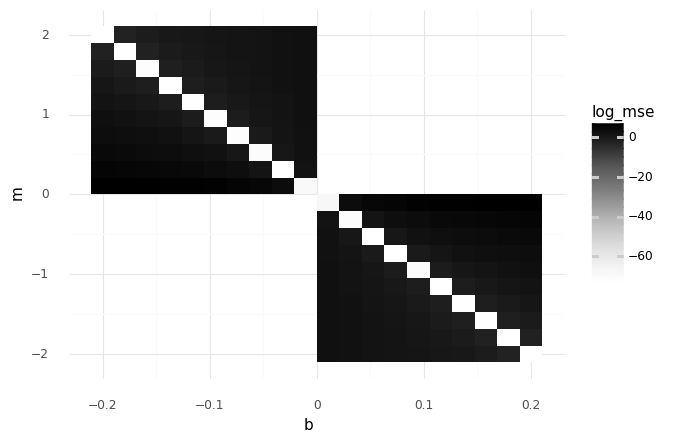

<ggplot: (8778599538249)>

In [13]:
## Visualize the grid of values
(
    ggplot(
        df_results 
        >> gr.tf_filter(
            ((X.b > 0) & (X.m < 0)) |
            ((X.b < 0) & (X.m > 0))
        )
        >> gr.tf_mutate(log_mse=gr.log(X.mse)), 
        aes("b", "m", fill="log_mse")
    )
    + scale_fill_cmap(name="Greys")
    + geom_tile()
    + theme_minimal()
)

Note that multiple pairs of `m, b` values lead to an identical MSE---this is the culprit for the unidentifiability of the model. Note that since `m, b` enter the model only through the ratio `m / b`, any pair of `m, b` values with the same ratio will give produce an identical model fit.

To fix this unidentifiability issue, we can *reformulate* the model.


### Resolution: Reformulation

Since the parameters `b, m` enter only as the combination $\tau = -b/m$ we can *reformulate* the model in terms of this combined parameter. The model `md_trajectory` is implemented this way; let's re-fit the model using this reformulated version.


In [14]:
md_trajectory_ref = (
    df_trajectory_windowed
    >> gr.ft_nls(
        md=md_trajectory,
        uq_method="linpool",
        method="SLSQP",
    )
)

... fit_nls setting out = ['y', 'x']
... eval_nls setting out = ['y', 'x']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = ['t']
        v0         u0      tau  v0_0  u0_0  tau_0  success  \
0  28.2348  18.792167  2.80225   0.1   0.1   0.05     True   

                                message  n_iter       mse  
0  Optimization terminated successfully      46  0.093358  
... provided columns intersect model output.
eval_df() is dropping {'y', 'x'}


Note that this version of the model does *not* issue the unidentifiable model warning; reformulating the model has resolved the identifiability issue! Furthermore the solver results indicate the optimization was successful---reformulating the model has also enabled successful fitting of the model.


### Challenge: Local Minima <a id="challenge-minima"></a>

Since NLS can be applied to arbitrary models, we have no guarantees about the existence of a single globally-optimal parameter value. Furthermore, since `fit_nls()` uses an iterative optimization procedure it can easily get "stuck" in a locally optimal model fit and fail to identify the globally optimal parameter value.

To illustrate the issue of local minima, let's look at a simple example of fitting a time-varying wave. 

$$Y(t) = a \cos(bt) + b \sin(at).$$


In [15]:
## Define wave model
md_wave = (
    gr.Model("Fast Wave")
    >> gr.cp_function(
        fun=lambda x: x[1] * np.cos(x[2] * x[0]) + x[2] * np.sin(x[1] * x[0]),
        var=["t", "a", "b"],
        out=["y"],
    )
    >> gr.cp_bounds(
        t=(0, 100),
        a=(90, 110),
        b=(102, 110),
    )
)

## Evaluate wave model to generate data; set a=100, b=102
df_wave_data = (
    md_wave
    >> gr.ev_df(df=gr.df_make(t=np.linspace(0, 30, num=200), a=100, b=102))
)

Let's try fitting this model with `fit_nls()`.


In [16]:
md_wave_fit = (
    df_wave_data[["y", "t"]]
    >> gr.ft_nls(md=md_wave)
)


... fit_nls setting out = ['y']
... eval_nls setting out = ['y']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = ['t']
            b     a    b_0    a_0  success  \
0  102.000451  90.0  106.0  100.0     True   

                                           message  n_iter           mse  
0  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH       4  10418.950765  


The solver results indicate that optimization was successful, but the MSE value seems to be quite large. Let's visually inspect the fit.


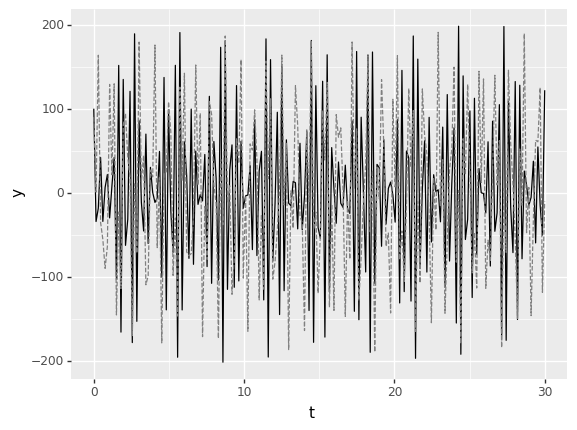

<ggplot: (8778600814209)>

In [17]:
## Visualize the fit
df_wave_fit = gr.eval_nominal(md_wave_fit, df_det=df_wave_data[["t"]])
(
    ggplot(mapping=aes("t", "y"))
    + geom_line(data=df_wave_data)
    + geom_line(data=df_wave_fit, linetype="dashed", color="grey")
)


This visual indicates that the fit is very poor; the peaks tend to line up but are frequently of incorrect magnitude. Periodic offsets in $b + 2\pi n$ lead to identical frequencies but different wave magnitudes---this leads to multiple minima for the MSE which complicates NLS.


### Partial Resolution: Restarts

A partial resolution is to enable the *multiple-restart* capability of `fit_nls()`; setting `n_restart` to a value greater than one uses the provided bounds / density to randomly sample initial parameter guesses $\theta_0$. The `fit_nls()` routine will automatically select the minimum MSE candidate.

Note that whenever using a random algorithm (such as random restarts), it is a good idea to set the `seed` parameter to a fixed integer for reproducibility of computations. One can also vary the seed to get a different random draw.


In [18]:
md_wave_fit2 = (
    df_wave_data[["y", "t"]]
    >> gr.ft_nls(
        md=md_wave,
        n_restart=5,
        seed=101,
    )
)


... fit_nls setting out = ['y']
... eval_nls setting out = ['y']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = ['t']
Design runtime estimates unavailable; model has no timing data.
            b      a         b_0         a_0  success  \
2  102.000031  110.0  103.372173  103.705540     True   
4  102.000031  110.0  103.519512  101.084552     True   
0  102.000451   90.0  106.000000  100.000000     True   
1  102.000451   90.0  106.131189  101.413352     True   
3  108.471973   90.0  104.455730  107.872262     True   

                                           message  n_iter           mse  
2  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH       3  10297.430927  
4  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH       3  10297.430927  
0  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH       4  10418.950765  
1  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH       3  10418.950765  
3  CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH       5  13184.849642  


Once again, we can see that optimization terminated successfully, but we have still gotten trapped in a local minimum.


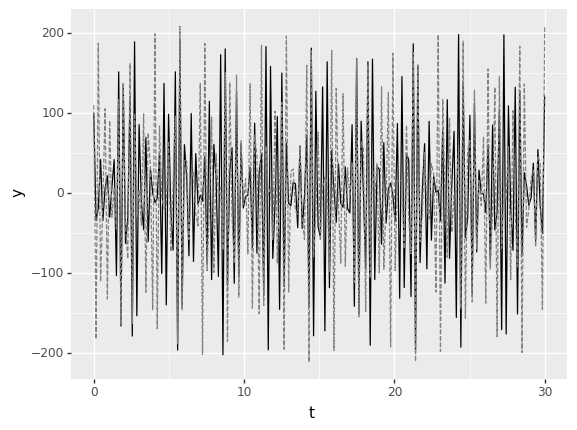

<ggplot: (8778599558621)>

In [19]:
df_wave_fit2 = gr.eval_nominal(md_wave_fit2, df_det=df_wave_data[["t"]])

(
    ggplot(mapping=aes("t", "y"))
    + geom_line(data=df_wave_data)
    + geom_line(data=df_wave_fit2, linetype="dashed", color="grey")
)

### Partial Resolution: Restrict parameter domain

To fully resolve this local minimum issue we will combine multiple-restarts with a constriction of the parameter space to be considered. Below we constrict the bounds for `a` and re-fit the model.


In [20]:
md_wave_restricted = (
    md_wave
    >> gr.cp_bounds(
        t=(0, 100),
        a=(100, 105), # Restrict bounds
        b=(102, 110),
    )
)

md_wave_fit3 = (
    df_wave_data[["y", "t"]]
    >> gr.ft_nls(
        md=md_wave_restricted,
        n_restart=5,
        seed=101
    )
)


... fit_nls setting out = ['y']
... eval_nls setting out = ['y']
... eval_nls setting var_fix = []
... eval_nls setting var_feat = ['t']
Design runtime estimates unavailable; model has no timing data.
            b           a         b_0         a_0  success  \
4  102.000000  100.000000  103.519512  102.771138     True   
0  107.906754  100.000000  106.000000  102.500000     True   
2  110.000000  100.001182  103.372173  103.426385     True   
3  110.000000  100.001182  104.455730  104.468065     True   
1  106.395971  103.008604  106.131189  102.853338     True   

                                            message  n_iter           mse  
4  CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL       1      0.000000  
0   CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH      16   9682.805373  
2   CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH       4   9923.663011  
3   CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH       4   9923.663011  
1   CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*E

Note that the optimal parameter value is the true set used to generate the data! By using more informed bounds we have successfully guided the optmization to the global minimum.


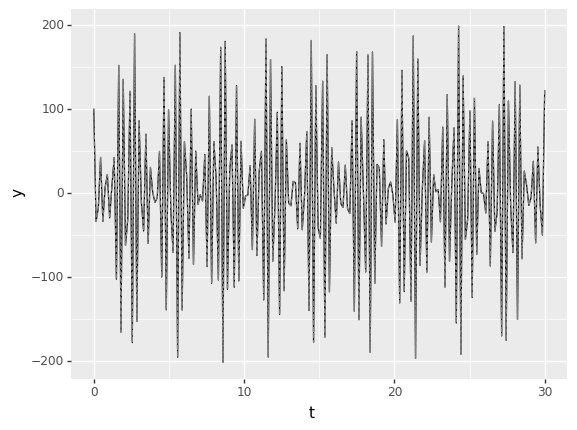

<ggplot: (8778600982321)>

In [21]:
df_wave_fit3 = gr.eval_nominal(md_wave_fit3, df_det=df_wave_data[["t"]])

(
    ggplot(mapping=aes("t", "y"))
    + geom_line(data=df_wave_data)
    + geom_line(data=df_wave_fit3, linetype="dashed", color="grey")
)

## Key Takeaways

- NLS is a general-purpose approach to fitting a model that is nonlinear in its parameters.
- The `fit_nls()` Grama routine provides a framework for fitting arbitrary Grama models.
- Premature termination of the NLS optimization can lead to an inaccurate fit. A solution is to tighten the optimizer tolerances.
- Model unidentifiability can prevent successful fitting. A solution is to reformulate the model to consolidate multiple parameters into a smaller set of parameters.
- Local minima in parameter space can prevent identification of the global parameter minimum. A solution is to use a combination of multiple restarts and more informed parameter bounds.


## Grama Routines <a id="grama"></a>

- The [Grama routine](https://github.com/zdelrosario/py_grama/blob/f8ec31640f7184560edb22b674e193d00367dfc0/grama/dfply/summary_functions.py#L231-L244) `gr.mse()` is a convenient way to compute the MSE in a data pipeline. This is useful when assessing a fitted model's accuracy.
- The [Grama routine](https://github.com/zdelrosario/py_grama/blob/bc008517e1a0d6b88884874ac506970bf4cc1499/grama/fit_synonyms.py#L23-L73) `gr.fit_nls()` performs NLS optimization of a model in order to find fitted parameter values and return a callable model. This is the 
- The [Grama routine](https://github.com/zdelrosario/py_grama/blob/bc008517e1a0d6b88884874ac506970bf4cc1499/grama/eval_opt.py#L18-L71) `gr.eval_nls()` performs NLS optimization of a model against data in order to find fitted parameter values.
